# Key tasks:
1. Model architecture definition
2. Training loop
3. Validation
4. Model saving

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from PIL import Image
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import os

In [3]:
# Load Data
with open('../Data/processed_train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
    
with open('../Data/processed_test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)


In [6]:
def prepare_data(data):
    x=[]
    y=[]
    label_map={}
    
    for i, class_name in enumerate(data.keys()):
        label_map[class_name] = i

        for image in data[class_name]:
            try:
                with Image.open(image) as img:
                    img_array = np.array(img)
                    x.append(img_array)
                    y.append(label_map[class_name])
            except Exception as e:
                print(f"Error loading image {image}: {e}")
                continue


    x = np.array(x)
    y = np.array(y)

    return x, y, label_map
    

x_train, y_train, label_map_train = prepare_data(train_data)
x_test, y_test, label_map_test = prepare_data(test_data)

print(x_train.shape)
print(y_train.shape)
print(label_map_train)

print(x_test.shape)
print(y_test.shape)
print(label_map_test)

print(x_train[0])
print(y_train[0])

print(x_test[0])
print(y_test[0])

(24499, 84, 84, 3)
(24499,)
{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}
(800, 84, 84, 3)
(800,)
{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}
[[[237 144 165]
  [232 140 161]
  [228 140 162]
  ...
  [232 139 157]
  [236 148 164]
  [245 161 176]]

 [[236 143 164]
  [232 140 161]
  [227 139 161]
  ...
  [232 139 157]
  [241 150 167]
  [250 166 181]]

 [[238 145 166]
  [237 145 166]
  [233 145 167]
  ...
  [237 143 161]
  [247 156 173]
  [255 168 184]]

 ...

 [[227 137 147]
  [231 138 149]
  [233 132 146]
  ...
  [236 134 130]
  [234 132 127]
  [231 130 122]]

 [[227 137 147]
  [230 137 148]
  [232 131 145]
  ...
  [237 135 131]
  [234 132 127]
  [232 131 123]]

 [[229 137 148]
  [233 137 149]
  [234 132 146]
  ...
  [239 140 135]
  [237 138 132]
  [237 136 128]]]
0
[[[108  89  82]
  [116  97  90]
  [126 106  99]
  ...
  [209 185 185]
  [205 181 181]
  [202 178 178]]

 [[117  98  91]
  [123 104  97]
  [130 110 103]
  ...


In [7]:
# Normalize data
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
num_classes = len(label_map_train)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

In [21]:
model = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:], kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    
    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.7),
    layers.Dense(num_classes, activation='softmax')

])

c:\Users\mande\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Define callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

In [25]:
history = model.fit(
    x_train, y_train_cat,
    epochs=30,
    batch_size=128,
    validation_data=(x_test, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

test_loss, test_acc = model.evaluate(x_test, y_test_cat)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.6021 - loss: 2.1070 - val_accuracy: 0.1800 - val_loss: 4.1884 - learning_rate: 0.0010
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.6029 - loss: 1.9962 - val_accuracy: 0.2250 - val_loss: 4.1843 - learning_rate: 0.0010
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6188 - loss: 1.7617 - val_accuracy: 0.2087 - val_loss: 3.5312 - learning_rate: 0.0010
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.6284 - loss: 1.6785 - val_accuracy: 0.2288 - val_loss: 3.1952 - learning_rate: 0.0010
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.6365 - loss: 1.5901 - val_accuracy: 0.2237 - val_loss: 4.4358 - learning_rate: 0.0010
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.6405 - loss: 1.5680 - val_accuracy: 0.2925 - val_loss: 2.9395 - learning_rate: 0.0010
Epoch 7/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.6501 - loss: 1.

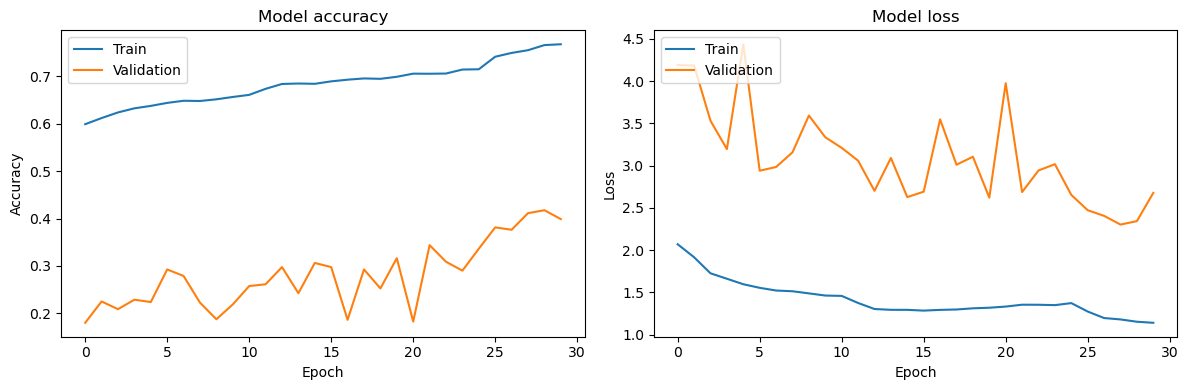

In [26]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

x_test shape: (800, 84, 84, 3)
y_test shape: (800, 8)
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
y_pred shape: (800, 8)
Classification Report:
                               precision    recall  f1-score   support

       Actinic Keratosis (AK)       0.00      0.00      0.00       100
   Basal Cell Carcinoma (BCC)       0.12      1.00      0.22       100
       Benign Keratosis (BKL)       0.00      0.00      0.00       100
          Dermatofibroma (DF)       0.00      0.00      0.00       100
               Melanoma (MEL)       0.00      0.00      0.00       100
       Melanocytic Nevus (NV)       0.00      0.00      0.00       100
Squamous Cell Carcinoma (SCC)       0.00      0.00      0.00       100
       Vascular Lesion (VASC)       0.00      0.00      0.00       100

                     accuracy                           0.12       800
                    macro avg       0.02      0.12      0.03       800
                 weighted avg       0.02      0.12      0.03       800

ROC-A

c:\Users\mande\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mande\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mande\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


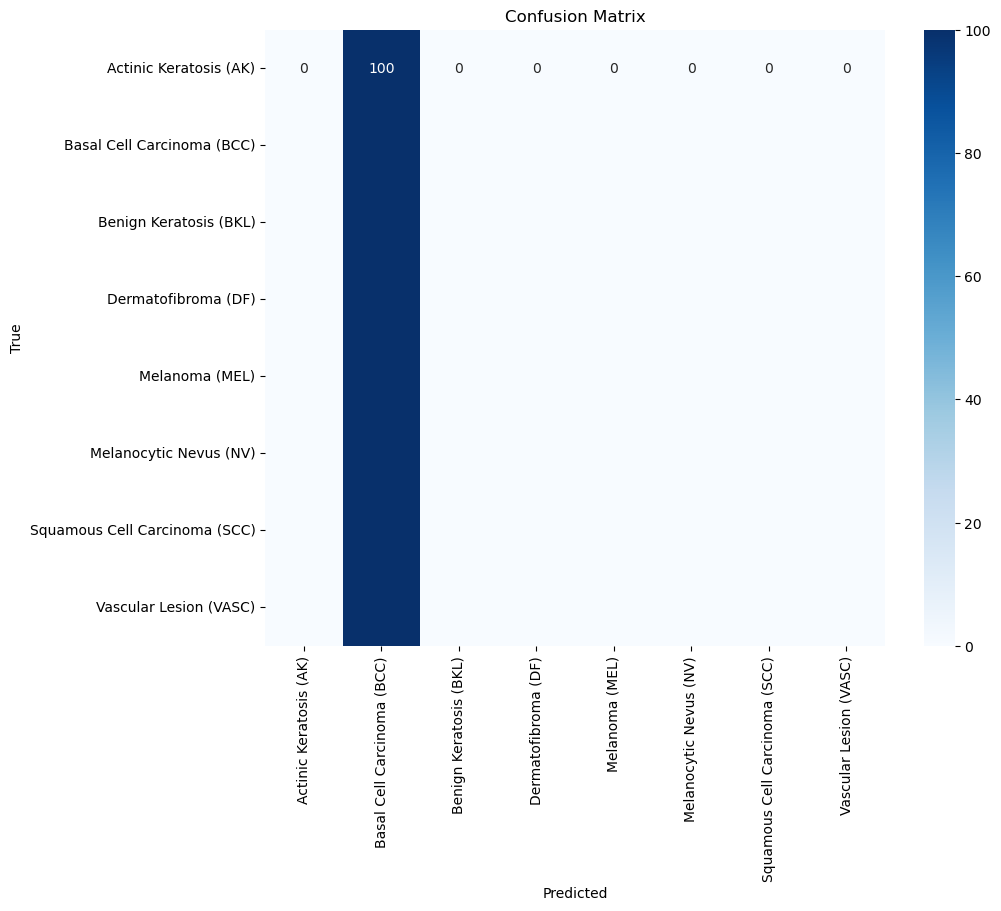

In [34]:
print("x_test shape:", x_test.shape)  # Expected: (800, 84, 84, 3) or similar
print("y_test shape:", y_test.shape)  # Expected: (800, 8) for one-hot, or (800,) for integer labels

# Preprocess x_test (ensure normalization and correct shape)
x_test = x_test.astype('float32') / 255.0  # Normalize to [0, 1]
# If model expects different size (e.g., 84x84), resize if needed
# x_test = tf.image.resize(x_test, [84, 84]).numpy()

# Check if y_test is one-hot encoded; convert if integer labels
if len(y_test.shape) == 1 or y_test.shape[1] == 1:
    print("Converting y_test to one-hot encoded format")
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=8)

# Generate predictions
try:
    y_pred = model.predict(x_test)
    print("y_pred shape:", y_pred.shape)  # Expected: (800, 8)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
except Exception as e:
    print(f"Error in prediction: {e}")
    raise

# Classification report
class_names = [
    'Actinic Keratosis (AK)',
    'Basal Cell Carcinoma (BCC)',
    'Benign Keratosis (BKL)',
    'Dermatofibroma (DF)',
    'Melanoma (MEL)',
    'Melanocytic Nevus (NV)',
    'Squamous Cell Carcinoma (SCC)',
    'Vascular Lesion (VASC)'
]
print("Classification Report:")
try:
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))
except Exception as e:
    print(f"Error in classification report: {e}")
    raise

# ROC-AUC score
try:
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    print(f"ROC-AUC (One-vs-Rest): {roc_auc:.4f}")
except ValueError as e:
    print(f"ROC-AUC calculation failed: {e}")

# Confusion Matrix Heatmap (for report)
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)  # Save for report
plt.show()